In [2]:
import os
import torchvision.models as models 
import torch.nn as nn
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm.auto import tqdm
import torchmetrics
import cv2
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Type_class='Type_All'
batch_size=256

In [9]:
#dataload
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res

class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
    
train_csv_path ='../../data/AF/Waveform_30/train/'
test_csv_path ='../../data/AF/Waveform_30/test/'

train_data_list=glob(train_csv_path+Type_class+'/**/*.csv')
test_data_list=glob(test_csv_path+Type_class+'/**/*.csv')
train_data=torch.empty(len(train_data_list),1,750)
train_label=torch.empty(len(train_data_list),1)
test_data=torch.empty(len(test_data_list),1,750)
test_label=torch.empty(len(test_data_list),1)
for i in tqdm(range(len(train_data_list))):
    signal_csv=pd.read_csv(train_data_list[i])['PPG'].to_numpy()
    train_data_list[i].find('positive')
    AF_signal_label=0
    if train_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    signal_csv=signal_csv-signal_csv.min()
    signal_csv=signal_csv/signal_csv.max()
    train_data[i]=torch.tensor(resized(signal_csv,750))
    train_label[i]=torch.tensor([AF_signal_label])
    
for i in tqdm(range(len(test_data_list))):
    signal_csv=pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label=0
    if test_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    signal_csv=signal_csv-signal_csv.min()
    signal_csv=signal_csv/signal_csv.max()
    test_data[i]=torch.tensor(resized(signal_csv,750))
    test_label[i]=torch.tensor([AF_signal_label])

train_dataset=CustomDataset(train_data,train_label)
test_dataset=CustomDataset(test_data ,test_label)
dataset_size = len(test_dataset)
test_size = int(dataset_size * 0.5)
validation_size = dataset_size-test_size
validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/22184 [00:00<?, ?it/s]

  0%|          | 0/5460 [00:00<?, ?it/s]

In [10]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D,self).__init__()
        self.conv1=nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout1d(0.5)
        self.pool1=torch.nn.MaxPool1d(kernel_size=5)
        self.conv2=nn.Conv1d(in_channels=50, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu2=nn.ReLU()
        self.dropout2=nn.Dropout1d(0.5)
        self.pool2=torch.nn.MaxPool1d(kernel_size=5)
        self.fc1=nn.Linear(1500, 200, bias=False)
        self.fc2=nn.Linear(200, 1, bias=False)
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.dropout2(x)
        x=self.pool2(x)
        x = torch.flatten(x, 1)
        x=self.fc1(x)
        x=self.fc2(x)
        return x


    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = CNN1D().to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
summary(model,(batch_size,1,750))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [256, 1]                  --
├─Conv1d: 1-1                            [256, 50, 750]            200
├─ReLU: 1-2                              [256, 50, 750]            --
├─Dropout1d: 1-3                         [256, 50, 750]            --
├─MaxPool1d: 1-4                         [256, 50, 150]            --
├─Conv1d: 1-5                            [256, 50, 150]            7,550
├─ReLU: 1-6                              [256, 50, 150]            --
├─Dropout1d: 1-7                         [256, 50, 150]            --
├─MaxPool1d: 1-8                         [256, 50, 30]             --
├─Linear: 1-9                            [256, 200]                300,000
├─Linear: 1-10                           [256, 1]                  200
Total params: 307,950
Trainable params: 307,950
Non-trainable params: 0
Total mult-adds (M): 405.17
Input size (MB): 0.77
Forward/backward pass s

epoch: 1/1000 train_loss : 0.6986 train_accuracy: 0.5203 val_loss : 0.6858  val_accuracy: 0.4164
epoch: 2/1000 train_loss : 0.6432 train_accuracy: 0.5831 val_loss : 0.6178  val_accuracy: 0.5910


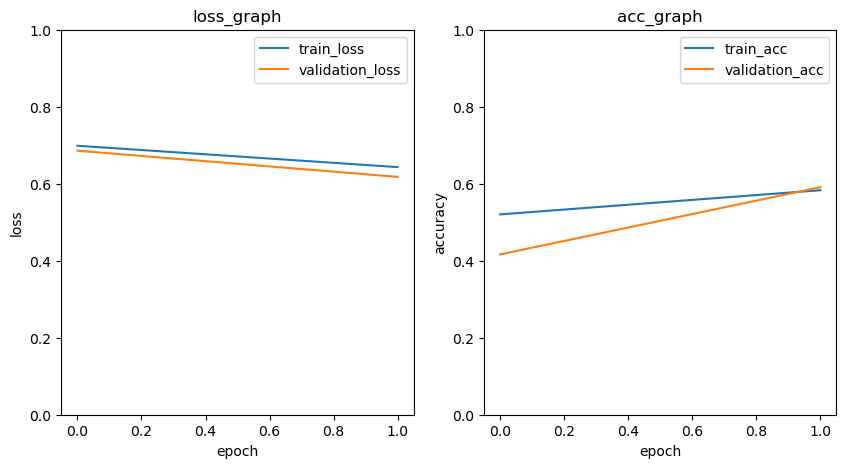

epoch: 3/1000 train_loss : 0.5897 train_accuracy: 0.6807 val_loss : 0.5104  val_accuracy: 0.7965
epoch: 4/1000 train_loss : 0.5361 train_accuracy: 0.7354 val_loss : 0.4257  val_accuracy: 0.8664
epoch: 5/1000 train_loss : 0.4924 train_accuracy: 0.7767 val_loss : 0.4208  val_accuracy: 0.8383
epoch: 6/1000 train_loss : 0.4555 train_accuracy: 0.8030 val_loss : 0.3458  val_accuracy: 0.8813
epoch: 7/1000 train_loss : 0.4206 train_accuracy: 0.8261 val_loss : 0.3187  val_accuracy: 0.8992
epoch: 8/1000 train_loss : 0.4072 train_accuracy: 0.8317 val_loss : 0.3253  val_accuracy: 0.8992
epoch: 9/1000 train_loss : 0.3855 train_accuracy: 0.8452 val_loss : 0.3185  val_accuracy: 0.8957
epoch: 10/1000 train_loss : 0.3795 train_accuracy: 0.8493 val_loss : 0.2981  val_accuracy: 0.9094
epoch: 11/1000 train_loss : 0.3802 train_accuracy: 0.8482 val_loss : 0.3064  val_accuracy: 0.9074
epoch: 12/1000 train_loss : 0.3640 train_accuracy: 0.8550 val_loss : 0.3099  val_accuracy: 0.8883
epoch: 13/1000 train_loss :

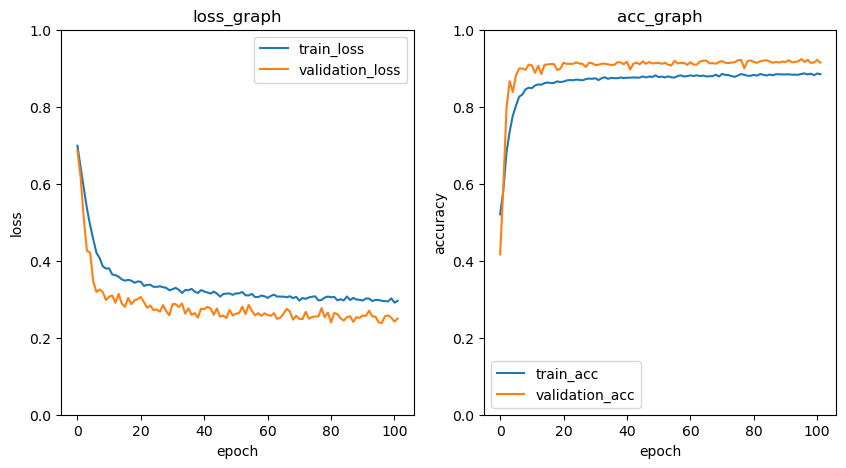

epoch: 103/1000 train_loss : 0.2975 train_accuracy: 0.8829 val_loss : 0.2397  val_accuracy: 0.9184
epoch: 104/1000 train_loss : 0.2948 train_accuracy: 0.8856 val_loss : 0.2428  val_accuracy: 0.9137
epoch: 105/1000 train_loss : 0.2931 train_accuracy: 0.8866 val_loss : 0.2441  val_accuracy: 0.9219
epoch: 106/1000 train_loss : 0.2928 train_accuracy: 0.8860 val_loss : 0.2647  val_accuracy: 0.9176
epoch: 107/1000 train_loss : 0.2922 train_accuracy: 0.8853 val_loss : 0.2539  val_accuracy: 0.9199
epoch: 108/1000 train_loss : 0.2877 train_accuracy: 0.8867 val_loss : 0.2534  val_accuracy: 0.9203
epoch: 109/1000 train_loss : 0.2920 train_accuracy: 0.8868 val_loss : 0.2645  val_accuracy: 0.9152
epoch: 110/1000 train_loss : 0.2966 train_accuracy: 0.8840 val_loss : 0.2591  val_accuracy: 0.9207
epoch: 111/1000 train_loss : 0.2941 train_accuracy: 0.8852 val_loss : 0.2494  val_accuracy: 0.9176
epoch: 112/1000 train_loss : 0.2932 train_accuracy: 0.8861 val_loss : 0.2555  val_accuracy: 0.9199
epoch: 113

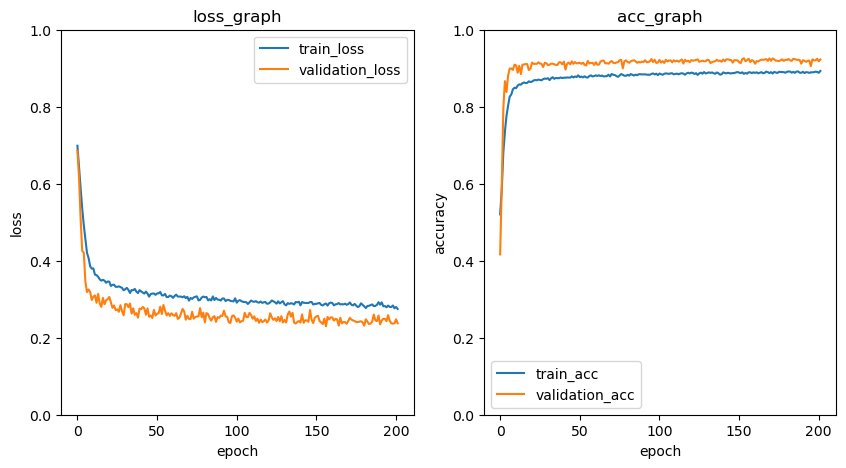

epoch: 203/1000 train_loss : 0.2833 train_accuracy: 0.8909 val_loss : 0.2448  val_accuracy: 0.9227
epoch: 204/1000 train_loss : 0.2846 train_accuracy: 0.8897 val_loss : 0.2418  val_accuracy: 0.9215
epoch: 205/1000 train_loss : 0.2841 train_accuracy: 0.8891 val_loss : 0.2364  val_accuracy: 0.9258
epoch: 206/1000 train_loss : 0.2825 train_accuracy: 0.8901 val_loss : 0.2340  val_accuracy: 0.9246
epoch: 207/1000 train_loss : 0.2831 train_accuracy: 0.8927 val_loss : 0.2352  val_accuracy: 0.9230
epoch: 208/1000 train_loss : 0.2834 train_accuracy: 0.8900 val_loss : 0.2553  val_accuracy: 0.9156
epoch: 209/1000 train_loss : 0.2809 train_accuracy: 0.8893 val_loss : 0.2382  val_accuracy: 0.9184
epoch: 210/1000 train_loss : 0.2804 train_accuracy: 0.8874 val_loss : 0.2460  val_accuracy: 0.9270
epoch: 211/1000 train_loss : 0.2864 train_accuracy: 0.8904 val_loss : 0.2332  val_accuracy: 0.9199
epoch: 212/1000 train_loss : 0.2842 train_accuracy: 0.8879 val_loss : 0.2261  val_accuracy: 0.9281
epoch: 213

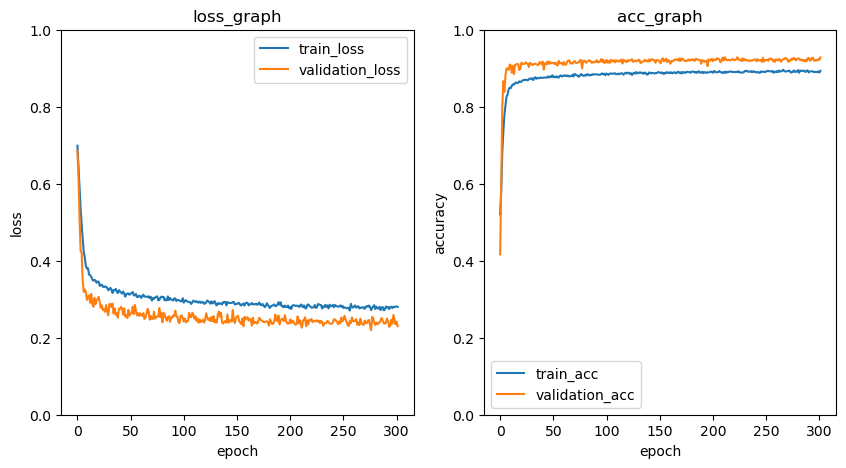

epoch: 303/1000 train_loss : 0.2812 train_accuracy: 0.8930 val_loss : 0.2410  val_accuracy: 0.9246
epoch: 304/1000 train_loss : 0.2737 train_accuracy: 0.8929 val_loss : 0.2454  val_accuracy: 0.9258
epoch: 305/1000 train_loss : 0.2767 train_accuracy: 0.8913 val_loss : 0.2501  val_accuracy: 0.9207
epoch: 306/1000 train_loss : 0.2791 train_accuracy: 0.8922 val_loss : 0.2498  val_accuracy: 0.9223
epoch: 307/1000 train_loss : 0.2734 train_accuracy: 0.8918 val_loss : 0.2383  val_accuracy: 0.9168
epoch: 308/1000 train_loss : 0.2774 train_accuracy: 0.8937 val_loss : 0.2384  val_accuracy: 0.9230
epoch: 309/1000 train_loss : 0.2772 train_accuracy: 0.8922 val_loss : 0.2512  val_accuracy: 0.9176
epoch: 310/1000 train_loss : 0.2783 train_accuracy: 0.8911 val_loss : 0.2416  val_accuracy: 0.9230
epoch: 311/1000 train_loss : 0.2735 train_accuracy: 0.8919 val_loss : 0.2439  val_accuracy: 0.9133
epoch: 312/1000 train_loss : 0.2783 train_accuracy: 0.8938 val_loss : 0.2450  val_accuracy: 0.9219
epoch: 313

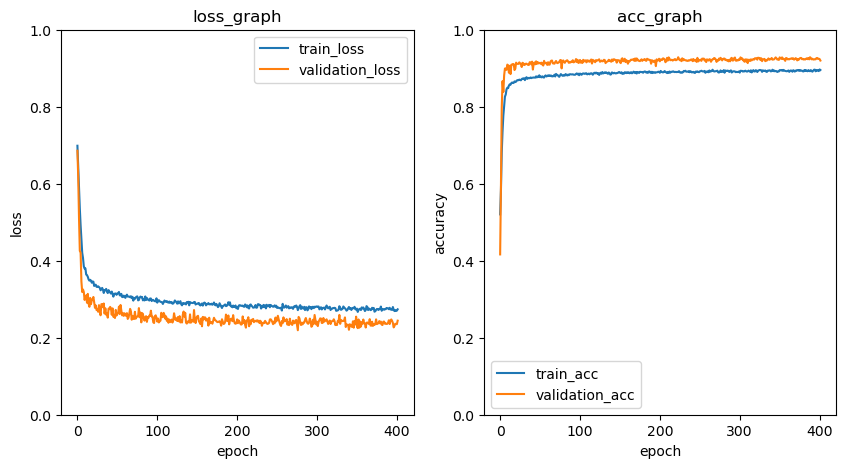

epoch: 403/1000 train_loss : 0.2717 train_accuracy: 0.8960 val_loss : 0.2419  val_accuracy: 0.9242
epoch: 404/1000 train_loss : 0.2702 train_accuracy: 0.8948 val_loss : 0.2306  val_accuracy: 0.9254
epoch: 405/1000 train_loss : 0.2729 train_accuracy: 0.8953 val_loss : 0.2384  val_accuracy: 0.9270
epoch: 406/1000 train_loss : 0.2726 train_accuracy: 0.8938 val_loss : 0.2365  val_accuracy: 0.9234
epoch: 407/1000 train_loss : 0.2726 train_accuracy: 0.8943 val_loss : 0.2387  val_accuracy: 0.9211
epoch: 408/1000 train_loss : 0.2760 train_accuracy: 0.8956 val_loss : 0.2543  val_accuracy: 0.9234
epoch: 409/1000 train_loss : 0.2679 train_accuracy: 0.8934 val_loss : 0.2345  val_accuracy: 0.9254
epoch: 410/1000 train_loss : 0.2709 train_accuracy: 0.8941 val_loss : 0.2456  val_accuracy: 0.9242
epoch: 411/1000 train_loss : 0.2717 train_accuracy: 0.8917 val_loss : 0.2359  val_accuracy: 0.9238
epoch: 412/1000 train_loss : 0.2727 train_accuracy: 0.8946 val_loss : 0.2660  val_accuracy: 0.9207
epoch: 413

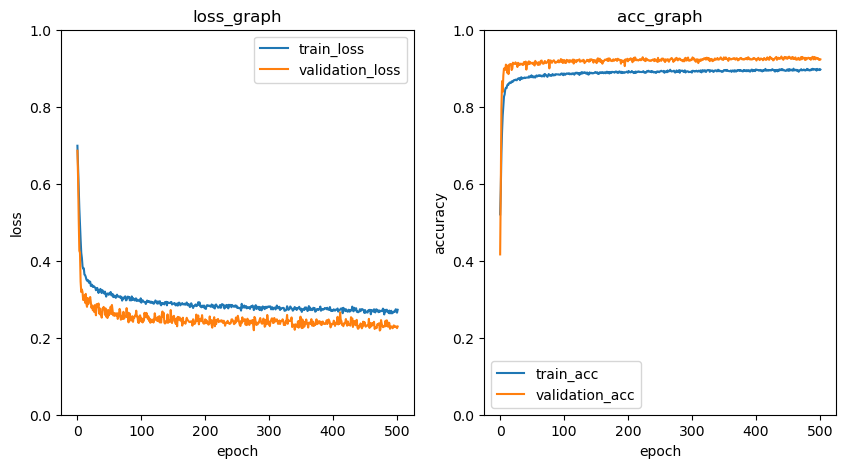

epoch: 503/1000 train_loss : 0.2682 train_accuracy: 0.8956 val_loss : 0.2270  val_accuracy: 0.9207
epoch: 504/1000 train_loss : 0.2649 train_accuracy: 0.8973 val_loss : 0.2266  val_accuracy: 0.9266
epoch: 505/1000 train_loss : 0.2707 train_accuracy: 0.8946 val_loss : 0.2232  val_accuracy: 0.9230
epoch: 506/1000 train_loss : 0.2639 train_accuracy: 0.8960 val_loss : 0.2349  val_accuracy: 0.9234
epoch: 507/1000 train_loss : 0.2645 train_accuracy: 0.8968 val_loss : 0.2302  val_accuracy: 0.9242
epoch: 508/1000 train_loss : 0.2662 train_accuracy: 0.8969 val_loss : 0.2257  val_accuracy: 0.9250
epoch: 509/1000 train_loss : 0.2666 train_accuracy: 0.8964 val_loss : 0.2266  val_accuracy: 0.9301
epoch: 510/1000 train_loss : 0.2655 train_accuracy: 0.8972 val_loss : 0.2328  val_accuracy: 0.9246
epoch: 511/1000 train_loss : 0.2674 train_accuracy: 0.8974 val_loss : 0.2247  val_accuracy: 0.9262
epoch: 512/1000 train_loss : 0.2657 train_accuracy: 0.8968 val_loss : 0.2215  val_accuracy: 0.9270
epoch: 513

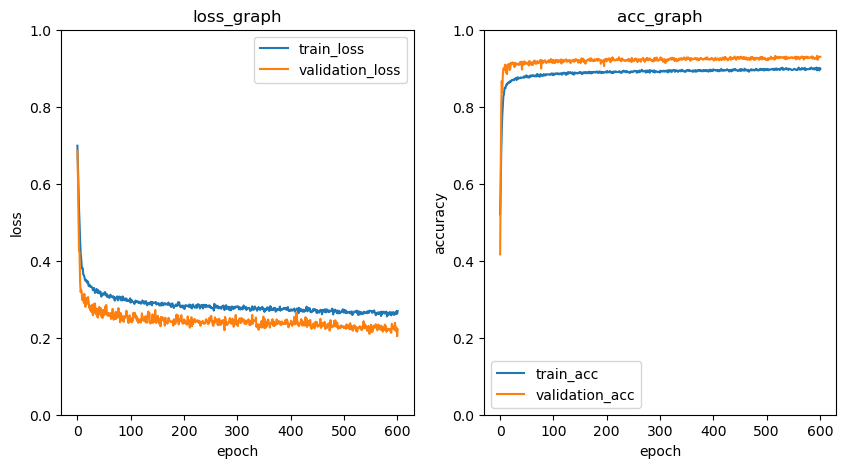

epoch: 603/1000 train_loss : 0.2643 train_accuracy: 0.8985 val_loss : 0.2186  val_accuracy: 0.9313
epoch: 604/1000 train_loss : 0.2631 train_accuracy: 0.8974 val_loss : 0.2239  val_accuracy: 0.9277
epoch: 605/1000 train_loss : 0.2629 train_accuracy: 0.8969 val_loss : 0.2283  val_accuracy: 0.9293
epoch: 606/1000 train_loss : 0.2671 train_accuracy: 0.8951 val_loss : 0.2240  val_accuracy: 0.9320
epoch: 607/1000 train_loss : 0.2592 train_accuracy: 0.8972 val_loss : 0.2284  val_accuracy: 0.9203
epoch: 608/1000 train_loss : 0.2617 train_accuracy: 0.8978 val_loss : 0.2224  val_accuracy: 0.9262
epoch: 609/1000 train_loss : 0.2632 train_accuracy: 0.8984 val_loss : 0.2329  val_accuracy: 0.9250
epoch: 610/1000 train_loss : 0.2570 train_accuracy: 0.9000 val_loss : 0.2274  val_accuracy: 0.9254
epoch: 611/1000 train_loss : 0.2638 train_accuracy: 0.8972 val_loss : 0.2226  val_accuracy: 0.9297
epoch: 612/1000 train_loss : 0.2652 train_accuracy: 0.8991 val_loss : 0.2359  val_accuracy: 0.9262
epoch: 613

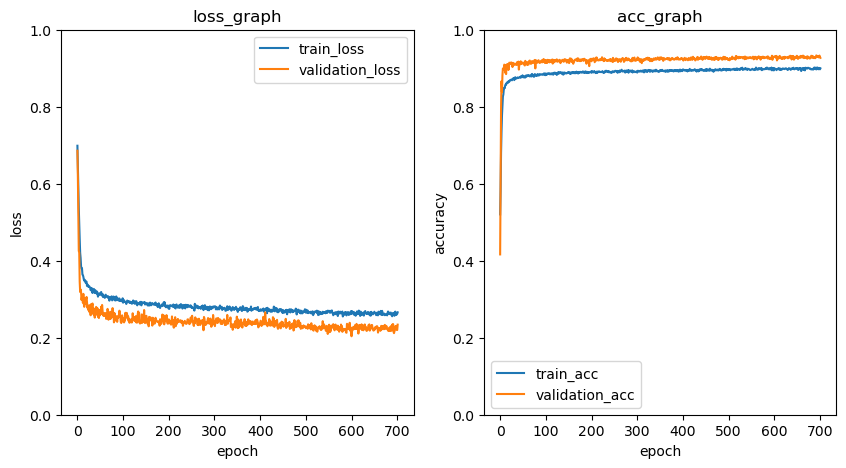

epoch: 703/1000 train_loss : 0.2596 train_accuracy: 0.9024 val_loss : 0.2367  val_accuracy: 0.9273
epoch: 704/1000 train_loss : 0.2589 train_accuracy: 0.8983 val_loss : 0.2174  val_accuracy: 0.9281
epoch: 705/1000 train_loss : 0.2663 train_accuracy: 0.9006 val_loss : 0.2239  val_accuracy: 0.9293
epoch: 706/1000 train_loss : 0.2610 train_accuracy: 0.8997 val_loss : 0.2115  val_accuracy: 0.9293
epoch: 707/1000 train_loss : 0.2574 train_accuracy: 0.8985 val_loss : 0.2270  val_accuracy: 0.9246
epoch: 708/1000 train_loss : 0.2620 train_accuracy: 0.8979 val_loss : 0.2184  val_accuracy: 0.9254
epoch: 709/1000 train_loss : 0.2652 train_accuracy: 0.8975 val_loss : 0.2227  val_accuracy: 0.9277
epoch: 710/1000 train_loss : 0.2547 train_accuracy: 0.9018 val_loss : 0.2166  val_accuracy: 0.9273
epoch: 711/1000 train_loss : 0.2655 train_accuracy: 0.8993 val_loss : 0.2297  val_accuracy: 0.9273
epoch: 712/1000 train_loss : 0.2630 train_accuracy: 0.8982 val_loss : 0.2218  val_accuracy: 0.9281
epoch: 713

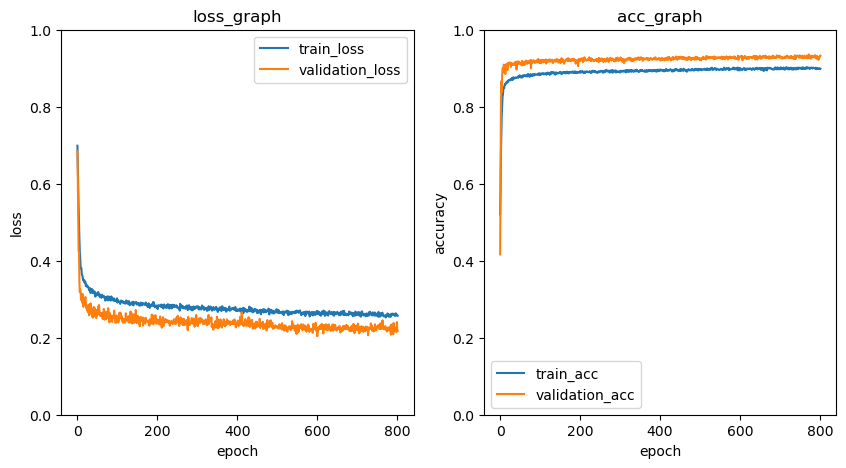

epoch: 803/1000 train_loss : 0.2645 train_accuracy: 0.8961 val_loss : 0.2261  val_accuracy: 0.9301
epoch: 804/1000 train_loss : 0.2636 train_accuracy: 0.8976 val_loss : 0.2272  val_accuracy: 0.9324
epoch: 805/1000 train_loss : 0.2613 train_accuracy: 0.8979 val_loss : 0.2303  val_accuracy: 0.9313
epoch: 806/1000 train_loss : 0.2662 train_accuracy: 0.9011 val_loss : 0.2171  val_accuracy: 0.9320
epoch: 807/1000 train_loss : 0.2622 train_accuracy: 0.8979 val_loss : 0.2241  val_accuracy: 0.9297
epoch: 808/1000 train_loss : 0.2584 train_accuracy: 0.8999 val_loss : 0.2261  val_accuracy: 0.9273
epoch: 809/1000 train_loss : 0.2589 train_accuracy: 0.9005 val_loss : 0.2194  val_accuracy: 0.9297
epoch: 810/1000 train_loss : 0.2532 train_accuracy: 0.9000 val_loss : 0.2253  val_accuracy: 0.9305
epoch: 811/1000 train_loss : 0.2549 train_accuracy: 0.8983 val_loss : 0.2166  val_accuracy: 0.9332
epoch: 812/1000 train_loss : 0.2563 train_accuracy: 0.9009 val_loss : 0.2048  val_accuracy: 0.9293
epoch: 813

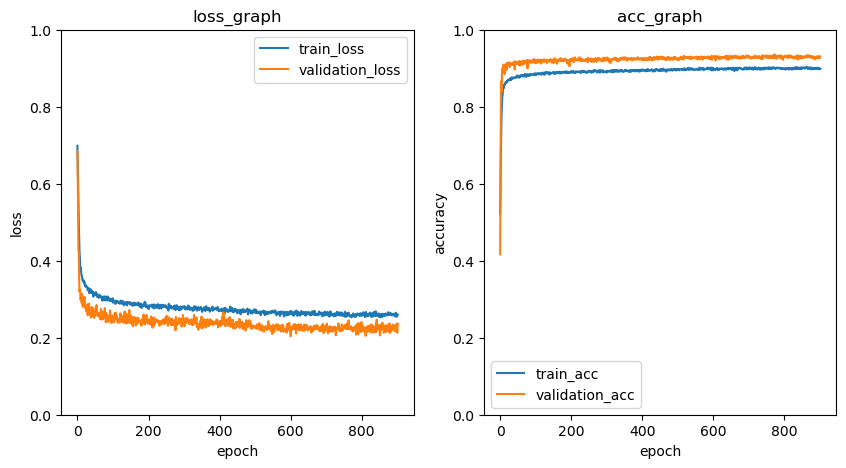

epoch: 903/1000 train_loss : 0.2591 train_accuracy: 0.8974 val_loss : 0.2213  val_accuracy: 0.9266
epoch: 904/1000 train_loss : 0.2577 train_accuracy: 0.9029 val_loss : 0.2232  val_accuracy: 0.9352
epoch: 905/1000 train_loss : 0.2569 train_accuracy: 0.9017 val_loss : 0.2402  val_accuracy: 0.9277
epoch: 906/1000 train_loss : 0.2579 train_accuracy: 0.8983 val_loss : 0.2197  val_accuracy: 0.9293
epoch: 907/1000 train_loss : 0.2635 train_accuracy: 0.8980 val_loss : 0.2173  val_accuracy: 0.9273
epoch: 908/1000 train_loss : 0.2563 train_accuracy: 0.9004 val_loss : 0.2122  val_accuracy: 0.9301
epoch: 909/1000 train_loss : 0.2585 train_accuracy: 0.8992 val_loss : 0.2204  val_accuracy: 0.9258
epoch: 910/1000 train_loss : 0.2583 train_accuracy: 0.9012 val_loss : 0.2207  val_accuracy: 0.9297
epoch: 911/1000 train_loss : 0.2563 train_accuracy: 0.9017 val_loss : 0.2258  val_accuracy: 0.9309
epoch: 912/1000 train_loss : 0.2603 train_accuracy: 0.9003 val_loss : 0.2209  val_accuracy: 0.9301
epoch: 913

In [11]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
for epoch in range(1000):
    
    train_count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train_dataloader:
        model.train()
        y = y.to(device0).float()
        train_count+=1
        x=x.to(device0).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device0)
        cost = criterion(predict, y) # cost 구함
        acc=accuracy(predict, y)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
    
    train_loss_list.append((running_loss/train_count))
    train_acc_list.append((acc_loss/train_count).cpu().detach().numpy())
#validation
    model.eval()
    val_count=0
    val_running_loss=0.0
    val_acc_loss=0
    with torch.no_grad():
        for x, y in validation_dataloader:
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            acc=accuracy(predict, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            val_acc_loss+=acc
        print(f"\repoch: {epoch+1}/{1000} train_loss : {running_loss/train_count:.4f} train_accuracy: {acc_loss/train_count:.4f} val_loss : {val_running_loss/val_count:.4f}  val_accuracy: {val_acc_loss/val_count:.4f}")
        
        val_loss_list.append((val_running_loss/val_count))
        val_acc_list.append((val_acc_loss/val_count).cpu().detach().numpy())
    if epoch%100==1:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
    if MIN_loss>(val_running_loss/val_count):
        torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/CNN_1D_call_back.pt')
        MIN_loss=(val_running_loss/val_count)
torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/CNN_1D.pt')